In [16]:
from model import *
from utils import *
from scipy.stats import kstest
import pickle
import pandas as pd

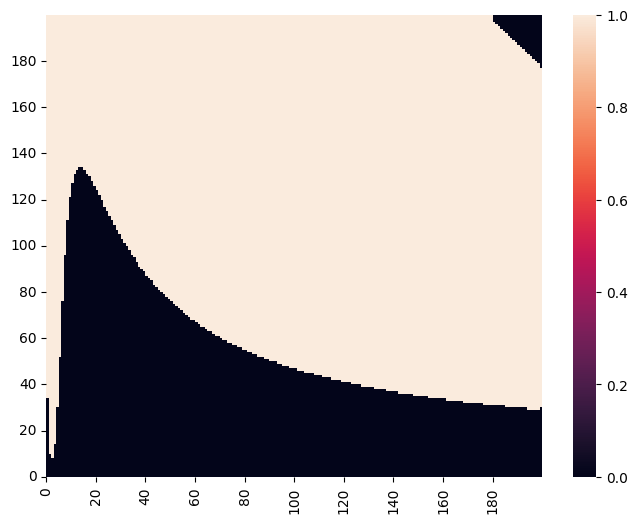

In [2]:
policy, params, _ = value_iteration(
    N=200,
    alpha=0.5,
    gamma=0.6,
    theta=0.88,
    omega=2.25,
    eta=0.88,
    beta=0.95,
    P_H_increase=0.9,
    invest_cost=1,
    health_delta=1,
    health_decrease_scale=1
)

plot_policy_boundary(policy, params)

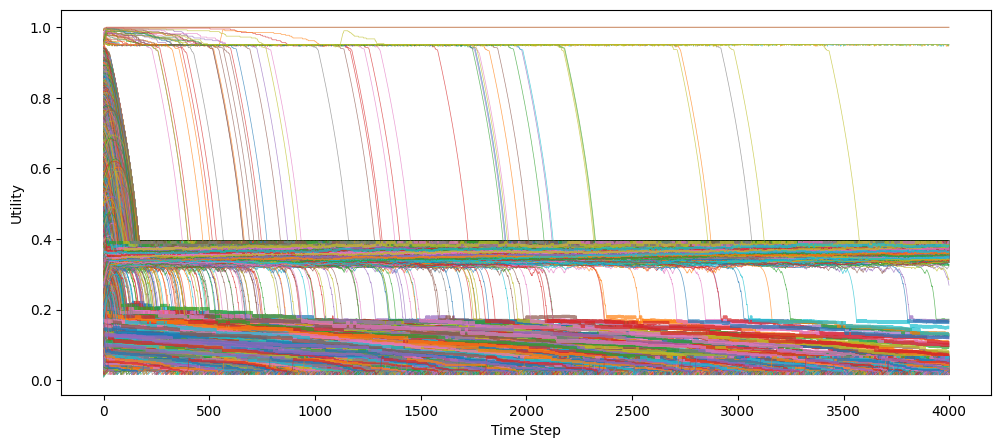

In [ ]:
num_steps = 4000
num_agents = 2000
util, wealth, health = simulate(
    params,
    policy,
    num_steps,
    num_agents
)
plot_utility_trajectories(util)

# Steady State

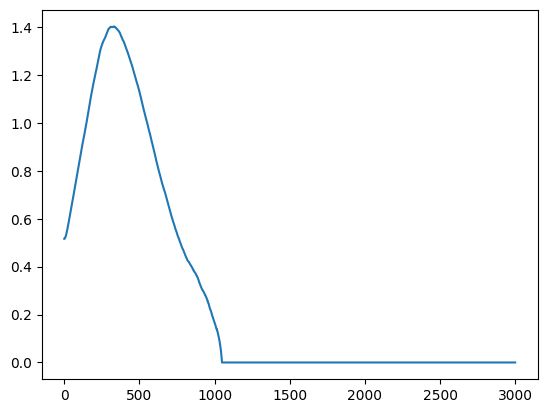

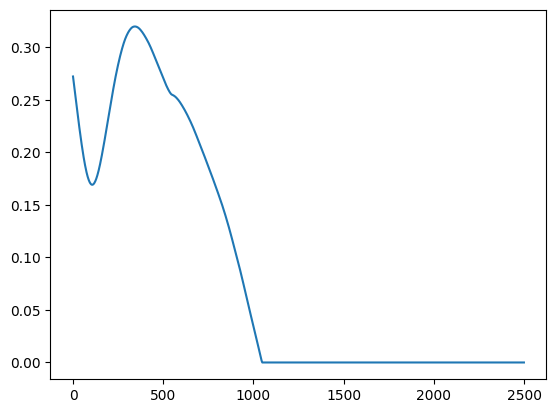

1041


In [259]:
cv = np.std(util, axis=0) / np.mean(util, axis=0)
plt.plot(cv)
plt.show()

cv_std = [np.std(cv[i:i+500]) for i in range(len(cv)-500)]
plt.plot(cv_std)
plt.show()

print(np.where(np.array(cv_std) < 0.005)[0][0])

431


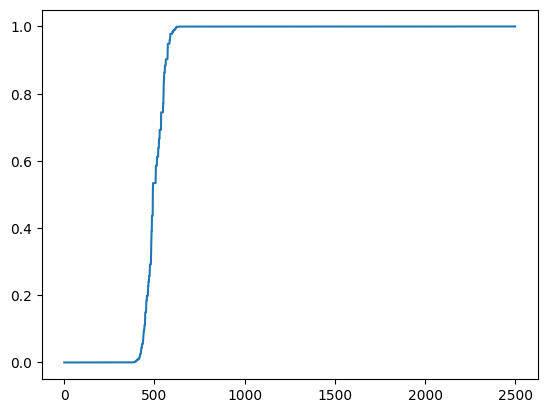

In [260]:
ks = [kstest(util[:,i], util[:,i+500]).pvalue for i in range(util.shape[1]-500)]
plt.plot(ks)
print(np.where(np.array(ks)>0.05)[0][0])

# Results

In [34]:
filepath = "results/0.5499853221699595_1_1.pickle"

with open(filepath, "rb") as f:
    res = pickle.load(f)

In [35]:
util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])

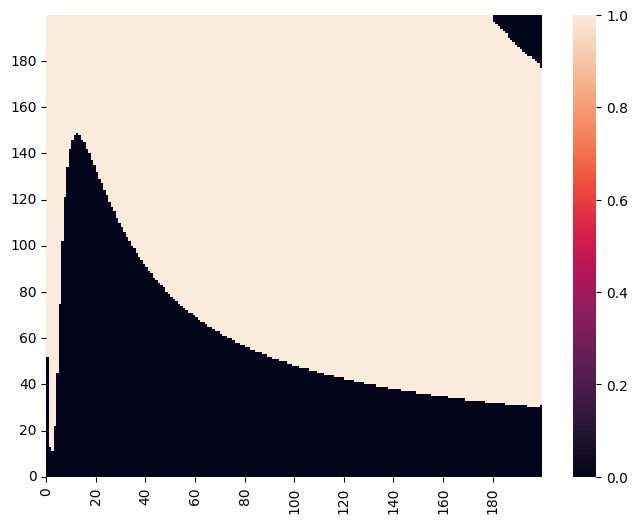

In [36]:
plot_policy_boundary(res["policy"], res["params"])

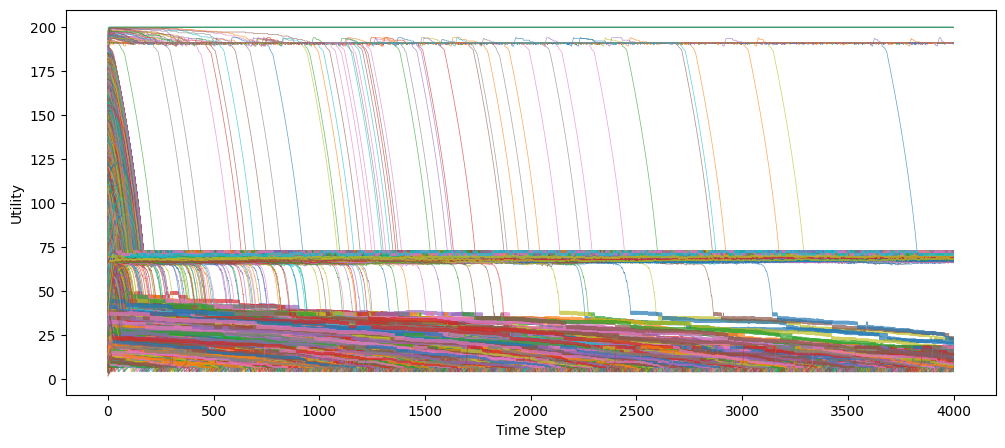

In [37]:
plot_utility_trajectories(util)

2769


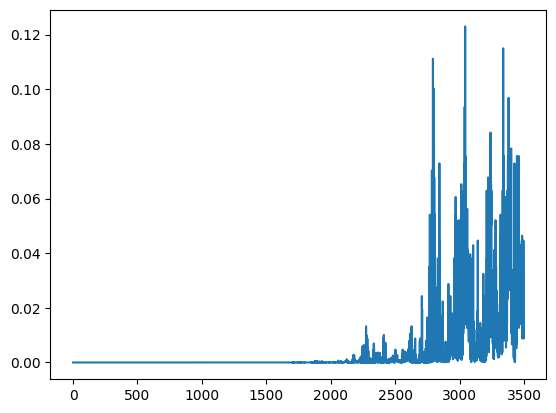

In [38]:
ks = [kstest(util[:,i], util[:,i+500]).pvalue for i in range(util.shape[1]-500)]
plt.plot(ks)
print(np.where(np.array(ks)>0.05)[0][0])